In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
%matplotlib inline

# 4.2.2 K-Means

## Applying the model

Let's try $k$-means on some [heart disease data](http://archive.ics.uci.edu/ml/datasets/Heart+Disease) from the UC Irvine Machine Learning Repository.  Our goal will be to create a $k$-means solution that correctly assigns patients to "heart disease diagnosis" or "no heart disease diagnosis" clusters.

In [7]:
# Grab data
df = pd.read_csv('processed.cleveland.data.txt', header=None)

# Define features and outcome
X = df.iloc[:, :13]
y = df.iloc[:, 13]

# Replace missing values (marked by ?) with a 0.
X = X.replace(to_replace='?', value=0)

# Binarize y so that 1 means heart disease diagnosis and 0 means no diagnosis.
y = np.where(y > 0, 0, 1)

To make it easier to visualize potential clusters, reduce the data to 2 components using PCA.

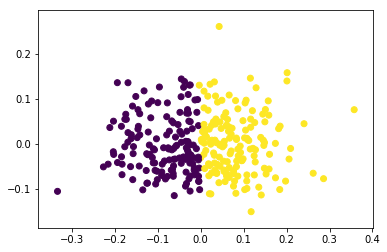

Comparing k-means clusters against the data:
col_0   0   1
row_0        
0      84  65
1      55  99


In [44]:
# Normalize the data.
X_norm = normalize(X)

# Reduce to two components.
X_pca = PCA(2).fit_transform(X_norm)

# Calculate predicted values.
y_pred = KMeans(n_clusters=2, random_state=42).fit_predict(X_pca)

# Plot the solution
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred)
plt.show()

# Check solution against the data
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_pred, y))

Looks like this model isn't doing very well. We're correctly classifying 182 cases, but mis-classifying 120 of the cases!

Now let's try MiniBatch:

In [32]:
# Each batch will be made up of 200 data points.
minibatchkmeans = MiniBatchKMeans(
    init='random',
    n_clusters=2,
    batch_size=200
)

minibatchkmeans.fit(X_pca)

# Add new predicted cluster memberships to the data frame.
predict_mini = minibatchkmeans.predict(X_pca)

# Check the MiniBatch model against our earlier one.
print('Comparing k-means and mini batch k-means solutions:')
print(pd.crosstab(predict_mini, y_pred))

#What is this cross tab telling us?  

Comparing k-means and mini batch k-means solutions:
col_0    0    1
row_0          
0        0  140
1      149   14


In [56]:
# This seems more informative. 
print(pd.crosstab(predict_mini, y))

col_0   0   1
row_0        
0      16  61
1      30   9
2      34  22
3      24  34
4      35  38


This marks a significant change. How substantial is the computational performance improvement? Try re-running the $k$-means and mini batch $k$-means models and timing their execution. Check out the [%timeit magic](https://ipython.org/ipython-doc/3/interactive/magics.html#magic-timeit) for helpful timing tools.

In [34]:
%timeit pass

# Fit and predict full batch.
y_pred = KMeans(n_clusters=2, random_state=42).fit_predict(X_pca)

8.43 ns ± 0.162 ns per loop (mean ± std. dev. of 7 runs, 100000000 loops each)


In [37]:
%timeit pass

# Fit and predict small batch.
minibatchkmeans = MiniBatchKMeans(
    init='random',
    n_clusters=2,
    batch_size=200
)

y_mini_pred = minibatchkmeans.fit_predict(X_pca)

8.29 ns ± 0.202 ns per loop (mean ± std. dev. of 7 runs, 100000000 loops each)


## Drill: More clusters?

Your task is to take the $k$-means code here and see what happens when you change the value of $k$.  What solution, if any, do you find most compelling? Does complexity start to become an issue with this data set? Play around a bit and write up your findings and your process to share with your mentor.  Keep in mind that it may be possible to have a solution with more than two clusters that is still better at tracking the real binary outcome – two of those clusters may map to "heart disease" while the other maps to "no heart disease," for example.

### Set k equal to number of original designations

In [43]:
df[13].describe()

count    303.000000
mean       0.937294
std        1.228536
min        0.000000
25%        0.000000
50%        0.000000
75%        2.000000
max        4.000000
Name: 13, dtype: float64

8.43 ns ± 0.284 ns per loop (mean ± std. dev. of 7 runs, 100000000 loops each)


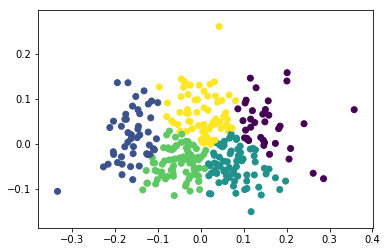

Comparing k-means clusters against the data:
13      0   1   2   3  4
row_0                   
0      21   5   5   3  2
1      12   9  13  11  3
2      58   7   2   3  2
3      45  18   8   7  1
4      28  16   8  11  5


In [54]:
# Original number of distinguishing values: k = 5

%timeit pass

y5 = df.iloc[:, 13]

# Calculate predicted values.
y_pred_5 = KMeans(n_clusters=5, random_state=42).fit_predict(X_pca)

# Plot the solution
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred_5)
plt.show()

# Check solution against the data
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_pred_5, y5))

Using k=5 performs very poorly.  Average accuracy is 14.5%. Processing time no different.

In [55]:
# Try with mini batches

%timeit pass

# Each batch will be made up of 200 data points.
minibatchkmeans = MiniBatchKMeans(
    init='random',
    n_clusters=5,
    batch_size=200
)

minibatchkmeans.fit(X_pca)

# Add new predicted cluster memberships to the data frame.
predict_mini = minibatchkmeans.predict(X_pca)

# Check the MiniBatch model against our earlier one.
print('Comparing k-means and mini batch k-means solutions:')
print(pd.crosstab(predict_mini, y5))

8.3 ns ± 0.108 ns per loop (mean ± std. dev. of 7 runs, 100000000 loops each)
Comparing k-means and mini batch k-means solutions:
13      0   1   2  3  4
row_0                  
0      61   8   2  4  2
1       9   7  12  9  2
2      22  11   8  9  6
3      34  10   6  6  2
4      38  19   8  7  1


Processing time no different.  Overall accuracy improved to 27.4%.

__Conclusions__

The two cluster model is more convincing, having significantly better accuracy.  It's also easy to interpret.  However, 5 clusters could point to different tiers of risk factor and help identify a patient who doesn't yet have heart disease but is on the brink.  